Performing Fourier Transform...


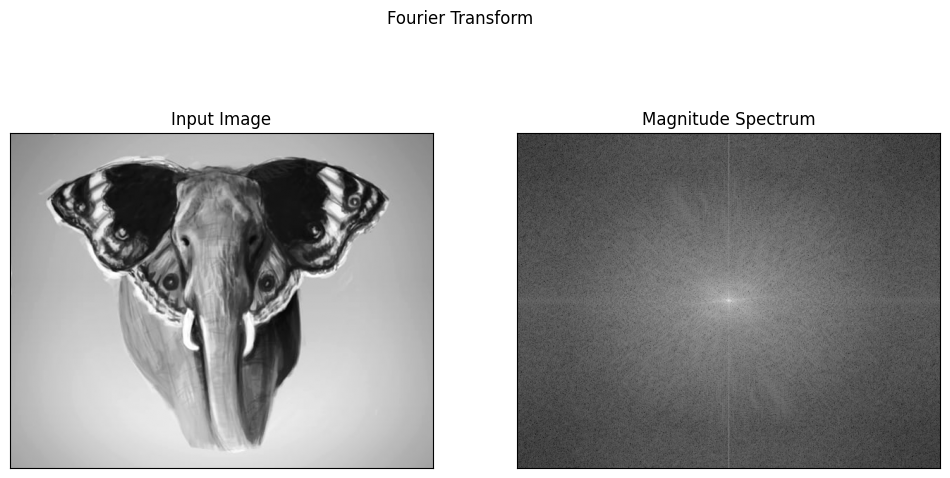


Restoring image with periodic noise...


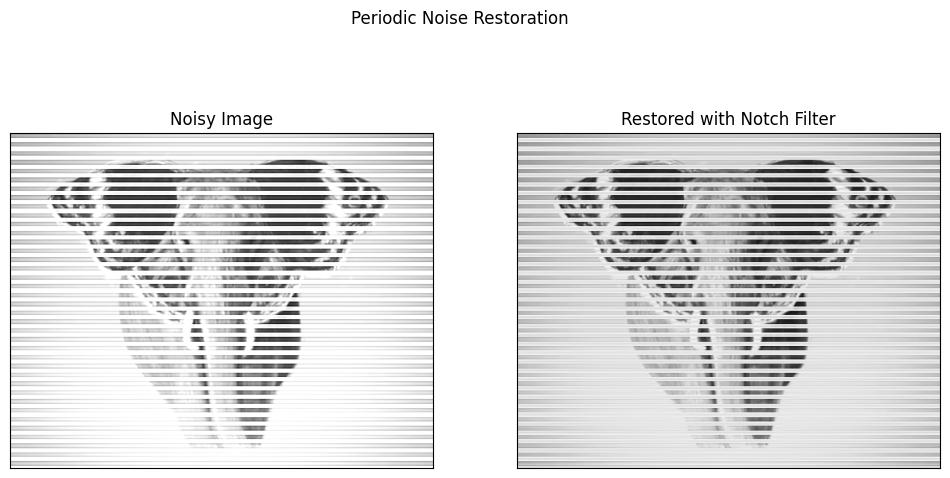


Restoring image with motion blur...


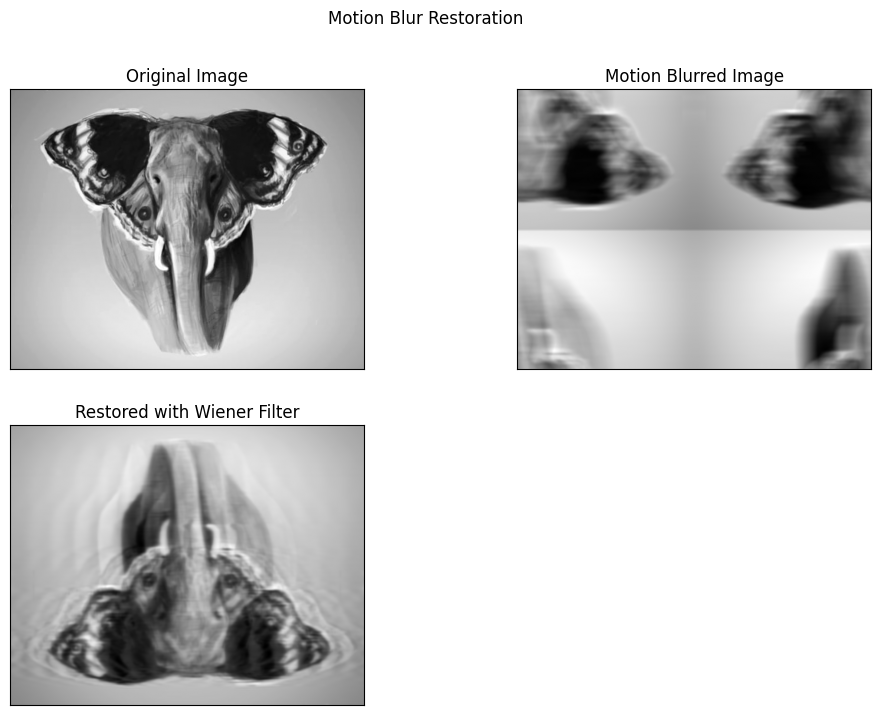


Processing complete.


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load the Image ---
try:
    img = cv2.imread('img1.jpg', 0)
    if img is None:
        raise FileNotFoundError("Image 'input.jpg' not found.")
    rows, cols = img.shape
except FileNotFoundError as e:
    print(e)
    exit()

print("Performing Fourier Transform...")

dft_shift = np.fft.fftshift(cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT))
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

# --- Display Fourier Transform Results ---
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Input Image')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray'), plt.title('Magnitude Spectrum')
plt.xticks([]), plt.yticks([])
plt.suptitle('Fourier Transform')
plt.show()

print("\nRestoring image with periodic noise...")

noise = np.zeros((rows, cols), dtype='uint8')
for r in range(rows):
    noise[r, :] = (np.sin(0.5 * r)) * 50 # Add a simple sinusoidal noise
noisy_img = cv2.add(img, noise)

noisy_dft_shift = np.fft.fftshift(cv2.dft(np.float32(noisy_img), flags=cv2.DFT_COMPLEX_OUTPUT))
crow, ccol = rows // 2, cols // 2
mask_notch = np.ones((rows, cols, 2), np.uint8)
# Place notches at the noise peaks (and their symmetric counterparts)
cv2.circle(mask_notch, (ccol, crow-80), 10, (0,0,0), -1)
cv2.circle(mask_notch, (ccol, crow+80), 10, (0,0,0), -1)


fshift_notch = noisy_dft_shift * mask_notch
f_ishift_notch = np.fft.ifftshift(fshift_notch)
img_restored_notch = cv2.idft(f_ishift_notch)
img_restored_notch = cv2.magnitude(img_restored_notch[:, :, 0], img_restored_notch[:, :, 1])
img_restored_notch = cv2.normalize(img_restored_notch, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)


plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(noisy_img, cmap='gray'), plt.title('Noisy Image')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_restored_notch, cmap='gray'), plt.title('Restored with Notch Filter')
plt.xticks([]), plt.yticks([])
plt.suptitle('Periodic Noise Restoration')
plt.show()


print("\nRestoring image with motion blur...")

psf = np.zeros((rows, cols))
psf[crow - 2:crow + 2, ccol - 20:ccol + 20] = 1
psf /= psf.sum() # Normalize

H = cv2.dft(np.float32(psf), flags=cv2.DFT_COMPLEX_OUTPUT)
F = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
G = cv2.mulSpectrums(F, H, 0)
blurred_img = cv2.magnitude(cv2.idft(np.fft.ifftshift(G))[:, :, 0], cv2.idft(np.fft.ifftshift(G))[:, :, 1])
blurred_img = cv2.normalize(blurred_img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

K = 0.01
H_mag_sq = cv2.magnitude(H[:,:,0], H[:,:,1])**2
wiener_term = H_mag_sq / (H_mag_sq + K)
F_hat_wiener_num = cv2.mulSpectrums(G, H, flags=cv2.DFT_ROWS, conjB=True)
F_hat_wiener_den = np.dstack([H_mag_sq]*2) # Create a 2-channel array for division
F_hat_wiener = cv2.divide(F_hat_wiener_num, F_hat_wiener_den + K) # G/H
img_restored_wiener = cv2.idft(np.fft.ifftshift(F_hat_wiener))
img_restored_wiener = cv2.magnitude(img_restored_wiener[:, :, 0], img_restored_wiener[:, :, 1])
img_restored_wiener = cv2.normalize(img_restored_wiener, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.figure(figsize=(12, 8))
plt.subplot(221), plt.imshow(img, cmap='gray'), plt.title('Original Image')
plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(blurred_img, cmap='gray'), plt.title('Motion Blurred Image')
plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(img_restored_wiener, cmap='gray'), plt.title('Restored with Wiener Filter')
plt.xticks([]), plt.yticks([])
plt.suptitle('Motion Blur Restoration')
plt.show()

print("\nProcessing complete.")